# **Data import and normalization**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import dbscan 

In [2]:
df = pd.read_excel("SAS_data_no_outliers.xlsx", index_col=0)
df.head()

Phone                          Email  NumOrders  AvgSum  \
0  55575449-54535553535073  56666668112117_pu26@yanded.ru          1  2420.0   
1  55574954-53565052504871           551120117_xu11@bk.ru          1  8999.0   
2  55575049-51505248534972   5566664122117_zu16@hotbox.ru          1  1790.0   
3  55574954-53495654564877                              0          1  1420.0   
5  55575456-52485253545172        53110109_nm16@gmail.com          1  3498.0   

   FullSum  AvgQuantity  AvgDiscount  Oneclick  Cancels  Actions  ...  \
0   2420.0          1.0          0.0       0.0      0.0      0.0  ...   
1   8999.0          1.0       2000.0       0.0      0.0      1.0  ...   
2   1790.0          1.0          0.0       0.0      0.0      0.0  ...   
3   1420.0          1.0          0.0       0.0      0.0      0.0  ...   
5   3498.0          2.0          0.0       0.0      0.0      0.0  ...   

   Упаковка  Встраиваемые духовые шкафы (VIP)  Товары для автолюбителей  \
0       0.0                                 0                       0.0   
1       0.0                                 0                       0.0   
2       0.0                                 0                       0.0   
3       0.0                                 0                       0.0   
5       0.0                                 0                       0.0   

   Ванная  Индивидуальные виды спорта  Сушильные машины  \
0     0.0                         0.0                 0   
1     0.0                         0.0                 0   
2     0.0                         0.0                 0   
3     0.0                         0.0                 0   
5     0.0                         0.0                 0   

   Встраиваемые микроволновые печи (VIP)  Аккумуляторы  Садовая мебель  \
0                                      0             0               0   
1                                      0             0               0   
2                                      0             0               0   
3                                      0             0               0   
5                                      0             0               0   

   Автоаудио  
0          0  
1          0  
2          0  
3          0  
5          0  

[5 rows x 149 columns]

In [3]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

scaler = MinMaxScaler()
norm_df = pd.DataFrame(scaler.fit_transform(df[numeric_columns]), columns=numeric_columns)

# **PCA**

In [4]:
pca = PCA()
pca.fit(norm_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(range(0, 147), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, 147, step=10))
plt.yticks(np.arange(.1, 1.1, step=0.1))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title("Number of components")
plt.grid()
plt.show()

In [5]:
pca = PCA(n_components=12, random_state=30)
pca.fit(norm_df)
pca_df = pca.fit_transform(norm_df)

# **K-Means**

## Determine number of clusters

### Elbow method

In [6]:
distances = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=33)
    kmeans.fit(pca_df)
    distances.append(kmeans.inertia_)

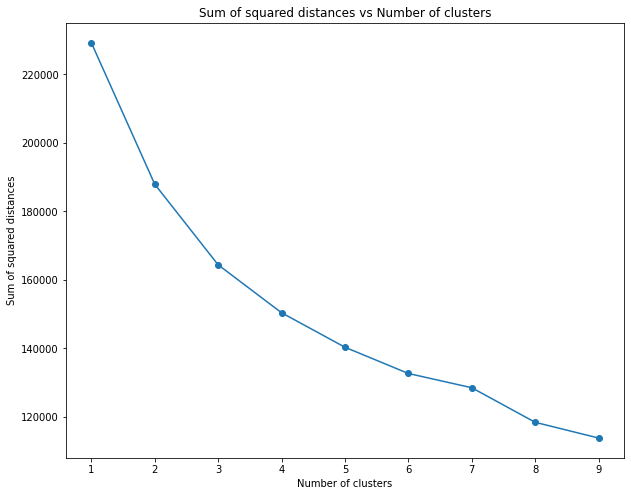

In [7]:
plt.plot(range(1, 10), distances, label="Distances")
plt.scatter(range(1, 10), distances)
plt.xticks(range(1, 10))
plt.title("Sum of squared distances vs Number of clusters")
plt.ylabel("Sum of squared distances")
# plt.vlines(7,ymin=5000, ymax=80000, linestyles='dashed', label="Elbow")
# plt.ylim(120000, 260000)
plt.xlabel("Number of clusters")
plt.show()

Метод локтя предполагает, что оптимальное количество кластеров составляет 5 или 6.

### Silhouette coefficient

In [8]:
silhouette = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=33)
    kmeans.fit(pca_df)
    silhouette.append(silhouette_score(pca_df, kmeans.labels_))

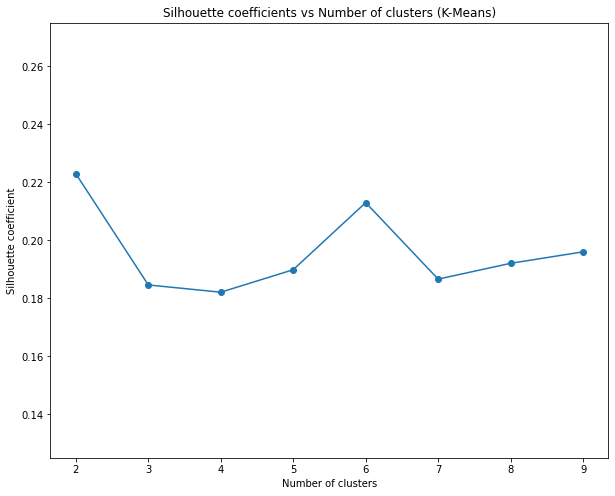

In [9]:
plt.plot(range(2, 10), silhouette, label="Silhouette coefficient")
plt.scatter(range(2, 10), silhouette)
plt.xticks(range(2, 10))
plt.title("Silhouette coefficients vs Number of clusters (K-Means)")
plt.ylabel("Silhouette coefficient")
plt.xlabel("Number of clusters")
plt.ylim(0.125, 0.275)
plt.show()

Для метода коэффициента силуэта оптимальным количеством кластеров является 2, однако 6 показывают довольно схожие результаты.

### Pie charts

In [10]:
def calculate_share(labels, n):
    share = []
    for i in range(n):
        share.append(len(labels[labels==i])/len(labels))
    return share

In [11]:
kmeans_2 = KMeans(n_clusters=2, random_state=33)
kmeans_2.fit(pca_df)
labels_2 = kmeans_2.labels_
share_2 = calculate_share(labels_2, 2)

kmeans_6 = KMeans(n_clusters=6, random_state=33)
kmeans_6.fit(pca_df)
labels_6 = kmeans_6.labels_
share_6 = calculate_share(labels_6, 6)

kmeans_8 = KMeans(n_clusters=8, random_state=33)
kmeans_8.fit(pca_df)
labels_8 = kmeans_8.labels_
share_8 = calculate_share(labels_8, 8)

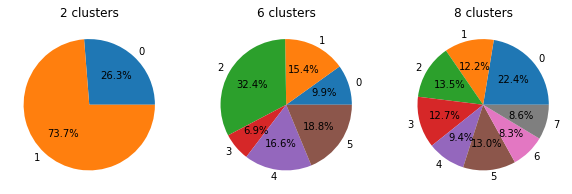

In [12]:
fig, axs = plt.subplots(1, 3)
axs[0].pie(share_2, labels=np.unique(labels_2), autopct='%1.1f%%')
axs[0].set_title("2 clusters")
axs[1].pie(share_6, autopct='%1.1f%%', labels=np.unique(labels_6))
axs[1].set_title("6 clusters")
axs[2].pie(share_8, autopct='%1.1f%%', labels=np.unique(labels_8))
axs[2].set_title("8 clusters")
plt.show()

Исходя из всех приведенных выше графиков, мы решили, что оптимальное количество кластеров равно 6.

## Perform K-Means

In [13]:
kmeans = KMeans(n_clusters=6, random_state=33)
kmeans.fit(pca_df)

KMeans(n_clusters=6, random_state=33)

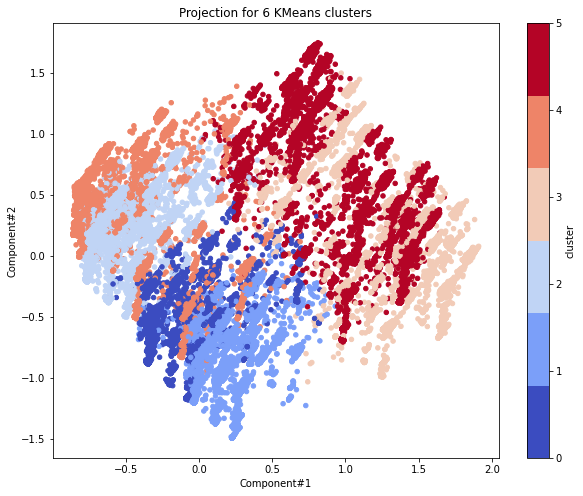

In [14]:
plt.scatter(pca_df[:,0], pca_df[:,1], c=kmeans.labels_, s=20, cmap=plt.cm.get_cmap('coolwarm', 6));
plt.title('Projection for {} KMeans clusters'.format(6))
plt.xlabel('Component#1')
plt.ylabel('Component#2')
plt.colorbar(ticks=[i for i in range(6)], label='cluster')
plt.show()

In [15]:
df['Cluster'] = kmeans.labels_
df.head()

Phone                          Email  NumOrders  AvgSum  \
0  55575449-54535553535073  56666668112117_pu26@yanded.ru          1  2420.0   
1  55574954-53565052504871           551120117_xu11@bk.ru          1  8999.0   
2  55575049-51505248534972   5566664122117_zu16@hotbox.ru          1  1790.0   
3  55574954-53495654564877                              0          1  1420.0   
5  55575456-52485253545172        53110109_nm16@gmail.com          1  3498.0   

   FullSum  AvgQuantity  AvgDiscount  Oneclick  Cancels  Actions  ...  \
0   2420.0          1.0          0.0       0.0      0.0      0.0  ...   
1   8999.0          1.0       2000.0       0.0      0.0      1.0  ...   
2   1790.0          1.0          0.0       0.0      0.0      0.0  ...   
3   1420.0          1.0          0.0       0.0      0.0      0.0  ...   
5   3498.0          2.0          0.0       0.0      0.0      0.0  ...   

   Встраиваемые духовые шкафы (VIP)  Товары для автолюбителей  Ванная  \
0                                 0                       0.0     0.0   
1                                 0                       0.0     0.0   
2                                 0                       0.0     0.0   
3                                 0                       0.0     0.0   
5                                 0                       0.0     0.0   

   Индивидуальные виды спорта  Сушильные машины  \
0                         0.0                 0   
1                         0.0                 0   
2                         0.0                 0   
3                         0.0                 0   
5                         0.0                 0   

   Встраиваемые микроволновые печи (VIP)  Аккумуляторы  Садовая мебель  \
0                                      0             0               0   
1                                      0             0               0   
2                                      0             0               0   
3                                      0             0               0   
5                                      0             0               0   

   Автоаудио  Cluster  
0          0        4  
1          0        5  
2          0        1  
3          0        2  
5          0        5  

[5 rows x 150 columns]

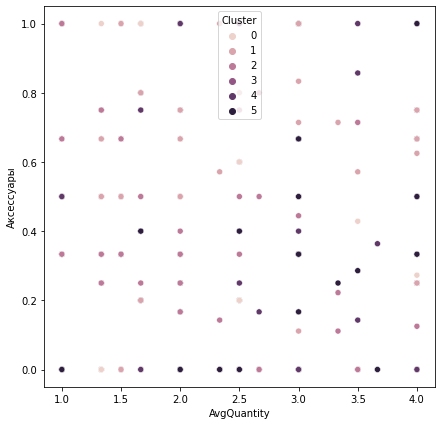

In [20]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x='AvgQuantity', y='Аксессуары', data=df, hue='Cluster')

In [21]:
groups = df.groupby(['Cluster']).mean()
groups

NumOrders        AvgSum       FullSum  AvgQuantity  AvgDiscount  \
Cluster                                                                    
0         1.081855   6317.220010   6841.073893     1.093940    93.082328   
1         1.082304   6601.450493   7104.639458     1.141342    80.029583   
2         1.106292   7806.802559   8661.269133     1.107333   111.044436   
3         1.047077  11849.314470  12395.153525     1.159670    17.425702   
4         1.075081   7398.890659   7917.279387     1.135230   162.531988   
5         1.046557  11384.859010  11939.713951     1.193309   171.510801   

         Oneclick   Cancels   Actions  LastOrderWeek    Moscow  ...  Упаковка  \
Cluster                                                         ...             
0        0.076315  0.005343  0.146045      12.918737  0.000000  ...  0.000000   
1        0.065408  0.010615  0.131096      12.918002  0.998131  ...  0.000000   
2        0.101645  0.008415  0.141295      12.908155  0.000710  ...  0.000018   
3        0.140607  0.026966  0.682982      12.919443  0.596703  ...  0.000000   
4        0.004261  0.004531  0.184557      12.848218  0.187773  ...  0.000035   
5        0.071887  0.002375  0.764248      13.035058  0.457432  ...  0.000000   

         Встраиваемые духовые шкафы (VIP)  Товары для автолюбителей    Ванная  \
Cluster                                                                         
0                                0.000000                  0.000000  0.000118   
1                                0.000000                  0.000076  0.000076   
2                                0.000000                  0.000235  0.000018   
3                                0.000000                  0.000000  0.000510   
4                                0.000000                  0.000176  0.000117   
5                                0.000062                  0.000094  0.000135   

         Индивидуальные виды спорта  Сушильные машины  \
Cluster                                                 
0                          0.000118          0.000000   
1                          0.000076          0.000000   
2                          0.000307          0.000000   
3                          0.000680          0.000000   
4                          0.000070          0.000070   
5                          0.000187          0.000062   

         Встраиваемые микроволновые печи (VIP)  Аккумуляторы  Садовая мебель  \
Cluster                                                                        
0                                     0.000000      0.000000        0.000000   
1                                     0.000000      0.000076        0.000000   
2                                     0.000036      0.000000        0.000036   
3                                     0.000000      0.000170        0.000000   
4                                     0.000000      0.000070        0.000000   
5                                     0.000000      0.000000        0.000000   

         Автоаудио  
Cluster             
0         0.000000  
1         0.000000  
2         0.000036  
3         0.000000  
4         0.000000  
5         0.000000  

[6 rows x 147 columns]

На основе таблицы сверху можно описать кластеры следующим образом:

1. 0 кластер - Покупатели в большинстве из Санкт-Петербурга. Использует самовывоз и платят наличными. Имеют средние показатели по скидке и самую низку сумму заказа, чаще всего покупают мелкую бытовую технику и тв-аудио.
1. 1 кластер -  покупатели из Москвы, это второй по средней сумме заказа кластер. Люди в 10% случаях оформляют отмену, забирают товары самовывозом и платят наличными при получении. Преимущественно покупают аксессуары.
1. 2 кластер - имеет самый большой показетель в частоте покупок(Покупатели приходят повторно). Покупатели преимущественно из других городов. Почти всегда забирают товар самовывозом и платят наличными при получении. Самыми популярными товарами явлются "Сделай Сам" и Фитнес.
1. 3 кластер - Самая большая выручка из всех кластеров и самое большое количество товаров в чеке 1-2. Самая низкая скидка из всех. Покупатели преимущественно из Москвы, но в немалых долях и из других городов. Реже всех оформляют онлайн-резерв и чаще всех звонят в колл-центр. Заказывают Курьерской доставкой и платят как картой так и наличными, но чаще наличными. Чаще всего покупают крупную бытовую технику, холодильное оборудование и мебель.
1. 4 кластер - Покупатели преимущественно из других городов. Имеют средние показатели в цене заказа и скидке. Часто делают онлайн-резерв. Забирают заказы самовывозом и платят картой при получении.Чаще всего покупают аксессуары и круаную бытовую технику.
1. 5 кластер - Имеет большую среднюю сумму заказа. Самая большую скидку средки всех покупателей. Больше всего действий совершается с товарами. Покупатели из всех городов и чаще всех делают онлайн-резерв. Заказывают товар Курьерской доставкой  и платят чаще всего наличными. Самыми популярные Категории товаров - мебель, крупные бытовые товары и детские игрушки.




# **DBSCAN**

In [22]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns

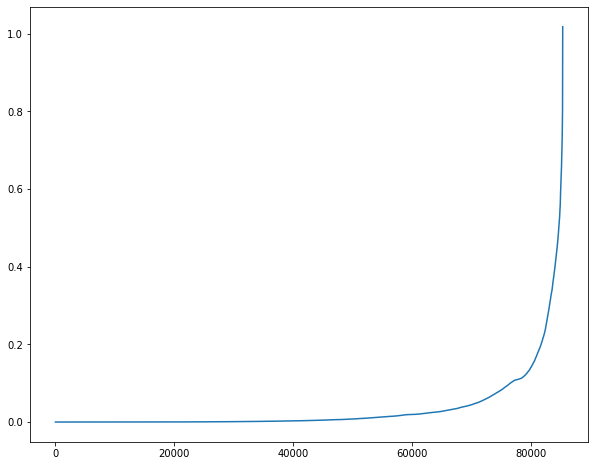

In [23]:
#find value for epsilon
neigh = NearestNeighbors(n_neighbors=24)
nbrs = neigh.fit(pca_df)
distances, indices = nbrs.kneighbors(pca_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

Выполним DBSCAN с эпсилоном, равным 0.2 (см. выше) и минимальными выборками, равными 2 * размерность набора данных (24).


In [24]:
dbscan = DBSCAN(eps=0.2, min_samples=24,)
clustering_labels = dbscan.fit_predict(pca_df)

In [25]:
silhouette_score(pca_df, clustering_labels)

0.29122049156383334

Как мы видим, коэффициент силуэта для DBSCAN значительно лучше, чем для K-means.

In [26]:
clus = np.unique(clustering_labels)
shares = []
for i in clus:
    shares.append(len(clustering_labels[clustering_labels==i])/len(clustering_labels))

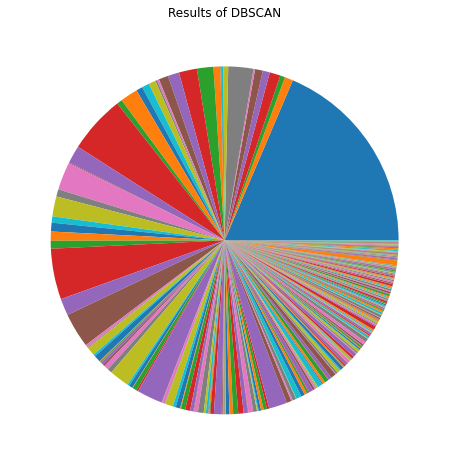

In [27]:
plt.pie(shares)
plt.title("Results of DBSCAN")
plt.show()

In [42]:
len(shares)

280

В результате работы DBSCAN получается 200+ кластеров, где один кластер составляет примерно 20%, а другие кластеры очень малы. Интерпретировать такие кластеры невозможно, поэтому DBSCAN не очень подходит для нашей задачи.

# **RFM**

In [28]:
df = pd.read_excel("SAS_data_no_outliers.xlsx", index_col=0)

In [29]:
rfm_df = df[['Phone', 'LastOrderWeek', 'NumOrders', 'FullSum']]

In [30]:
score_1 = np.full((1, 28504), 1)
score_2 = np.full((1, int(rfm_df.shape[0] * 0.333)), 2)
score_3 = np.full((1, int(rfm_df.shape[0] * 0.333)), 3)

In [31]:
scores = np.hstack((score_1, score_2, score_3)).flatten()
scores

array([1, 1, 1, ..., 3, 3, 3])

In [32]:
rfm_df = rfm_df.sort_values(by=['LastOrderWeek'])
rfm_df['r_score'] = scores
rfm_df

Phone  LastOrderWeek  NumOrders  FullSum  r_score
0       55575449-54535553535073              9          1   2420.0        1
7873    55574852-56525156525079              9          1   3660.0        1
7874    55574950-55575350525572              9          1   1389.0        1
7875    55574854-55485048575177              9          1   1950.0        1
7876    55575655-50555255485370              9          1   9019.0        1
...                         ...            ...        ...      ...      ...
83676  55574952-545153485155725             17          1  12490.0        3
83675   55575057-56495454544971             17          1   9999.0        3
83674   55575453-51575551485075             17          1  35330.0        3
83672   55575053-48505757555570             17          1  22790.0        3
89448   55575452-55554849505278             17          1   1090.0        3

[85336 rows x 5 columns]

In [33]:
rfm_df['f_score'] = rfm_df['NumOrders']
rfm_df = rfm_df.sort_values(by=['FullSum'])
rfm_df['m_score'] = scores
rfm_df = rfm_df.sort_values(by=['LastOrderWeek', 'NumOrders', 'FullSum'])
rfm_df

Phone  LastOrderWeek  NumOrders  FullSum  r_score  \
9385   55574853-564957515451705              9          1    300.0        1   
3670    55575054-54514850484975              9          1    300.0        1   
2250    55574853-54565657495079              9          1    310.0        1   
2069    55574949-57485448484870              9          1    310.0        1   
3470   55574851-495248504952745              9          1    310.0        1   
...                         ...            ...        ...      ...      ...   
56271   55574955-52535053484872             17          3  57778.0        3   
38086  55574953-535249535457795             17          3  62939.0        3   
73123  55574853-555257535248795             17          3  68840.0        3   
77221  55574952-535357575649735             17          3  70056.0        3   
18057   55574954-53565256545672             17          3  71008.0        3   

       f_score  m_score  
9385         1        1  
3670         1        1  
2250         1        1  
2069         1        1  
3470         1        1  
...        ...      ...  
56271        3        3  
38086        3        3  
73123        3        3  
77221        3        3  
18057        3        3  

[85336 rows x 7 columns]

Выполним kmeans, используя только оценки RFM.

In [34]:
distances = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=33)
    kmeans.fit(rfm_df.iloc[:,4:])
    distances.append(kmeans.inertia_)

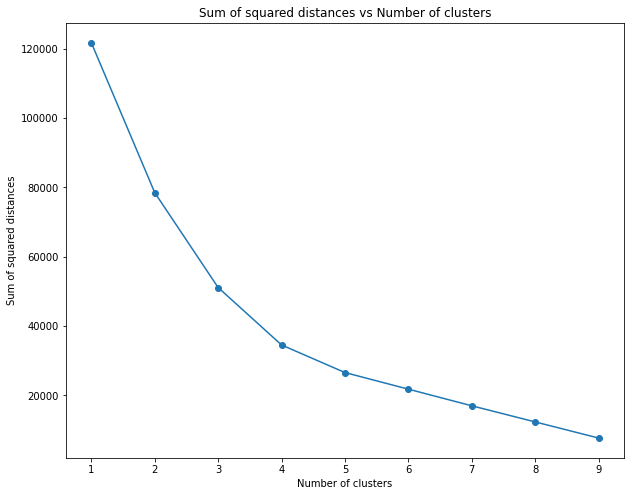

In [35]:
plt.plot(range(1, 10), distances, label="Distances")
plt.scatter(range(1, 10), distances)
plt.xticks(range(1, 10))
plt.title("Sum of squared distances vs Number of clusters")
plt.ylabel("Sum of squared distances")
plt.xlabel("Number of clusters")
plt.show()

Оптимальное количество кластеров - 4.

In [36]:
kmeans = KMeans(n_clusters=4, random_state=33)
kmeans.fit(rfm_df.iloc[:,4:])
rfm_df['Cluster'] = kmeans.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


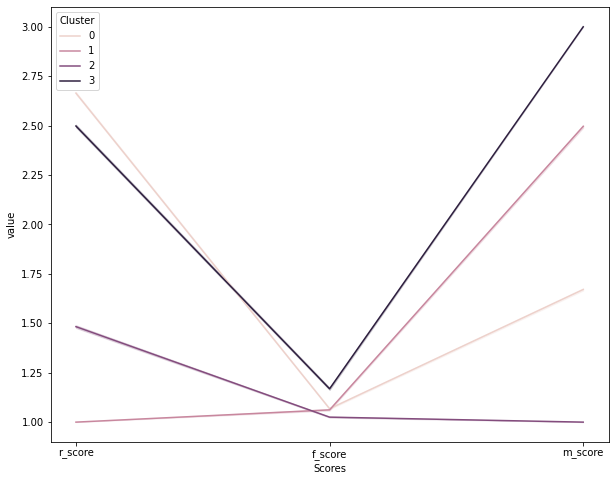

In [37]:
melted = pd.melt(rfm_df.reset_index(), id_vars=['Phone', 'Cluster'],
                 value_vars=['r_score', 'f_score', 'm_score'], var_name='Scores')
sns.lineplot('Scores', 'value', hue='Cluster', data=melted)
plt.show()

In [38]:
rfm_groups = rfm_df.groupby(['Cluster']).mean()
rfm_groups

LastOrderWeek  NumOrders       FullSum   r_score   f_score   m_score
Cluster                                                                      
0            14.929082   1.067923   4368.477390  2.664400  1.067923  1.671059
1             9.926800   1.062013  12270.822841  1.000000  1.062013  2.496154
2            11.343716   1.025252   1719.429848  1.482913  1.025252  1.000000
3            14.446303   1.168673  19909.564315  2.497994  1.168673  3.000000

Мы можем интерпретировать кластеры следующим образом:


1.   Кластер "0" - новые клиенты, купили что-то недавно, и пока имеют высокую ценность из-за недавней покупки и траты.
2.   Кластер "1" - клиенты, которых мы рискуем потерять, они совершали покупки довольно давно и потратили много денег.
3.   Кластер "2" - потерянные или почти потерянные клиенты, у них нет недавних заказов, частота и денежная ценность самые низкие.
4.   Кластер "3" - лучшие покупатели, они совершали покупки недавно, имеют наибольшую частоту и денежную стоимость.

